In [1]:
import pyccl as ccl
import numpy as np
import pylab as plt
import camb
from scipy import stats,optimize
import sys
import os
import astropy.constants as const
from scipy import interpolate
from bins import Bins

# Validation updates 

I am comparing Blast to both CCL and CAMB. Everything is close, but nothing is matching __yet__.

## Choose n(z)

I am using a smooth n(z) defined analytically (check out Marco's CosmoCentral.jl). With non-smooth bins, FKEM works poorly.

In [2]:
nofz = np.load("data/mynz.npy")
dndz = np.zeros((2,1000))
dndz[0,:] = nofz["z"]
dndz[1,:] = nofz["nz"]
z_W = np.array(dndz[0])
W = np.array(dndz[1])

In [3]:
zint = np.linspace(0,5,1024)
dndz = [zint,np.interp(zint,dndz[0],dndz[1])]

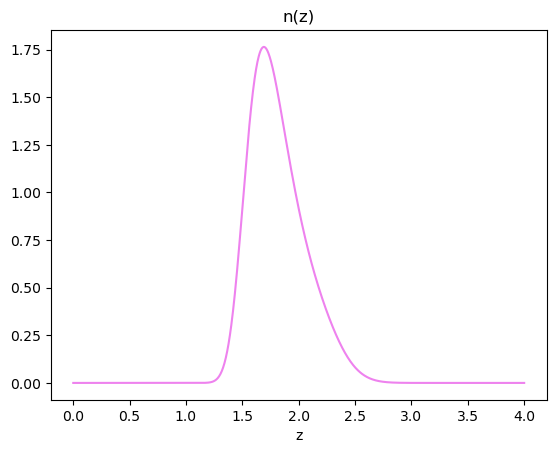

In [4]:
plt.plot(z_W, W, color="violet")
plt.xlabel("z")
plt.title("n(z)");

## Power spectrum situation

Obviously I need to make sure that every code is using the same power spectrum (linear and non linear), otherwise I will obviously have mismatches. I was able to generate the power spectrum and put it on the grid needed for Blast, using camb:

In [5]:
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

# Cosmology definition - adjusted to match blast one
h0 = 0.6727
Ob = 0.0492 
Odm= 0.2664 
As = np.e**3.047/1e10
ns = 0.9645 

In [6]:
# function to initialize camb parameters, from Giulio's notebook (with minor modification)
# currently, blast does the integral up to l = 200
def init_pars(lmin_limber=200,do_magnification_bias=0.,do_cmb = True, do_transfer=True):

    pars = camb.CAMBparams()
    lmax = 1000 #3*256-1
    print("lmin_limber: ", lmin_limber)
    pars.set_cosmology(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0, tau=0.0561)
    pars = camb.set_params(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0, tau=0.0561, halofit_version='takahashi')
    #As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = do_cmb
    pars.Want_transfer = do_transfer
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #pars.NonLinear = model.NonLinear_none

    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = lmin_limber
    if do_magnification_bias > 0:
        pars.SourceTerms.counts_lensing = False  # force to avoid confusion
    else:
        pars.SourceTerms.counts_lensing = False

    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False #weird problems at times
    pars.SourceTerms.counts_radial   = False # negligible at l<10
    pars.SourceTerms.counts_timedelay = False # negligible
    pars.SourceTerms.counts_ISW = False #negligible
    pars.SourceTerms.counts_velocity = False #negligible
    pars.SourceTerms.counts_potential = False #negligible
    pars.SourceTerms.counts_evolve = False # not sure what this is
    
    pars.Accuracy.LensingBoost = 2.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 2.0
    pars.Accuracy.SourcekAccuracyBoost=2.
    return pars

In [7]:
pars_nolimber = init_pars(lmin_limber = 200, do_magnification_bias = 0, do_cmb = True, do_transfer = False) 

lmin_limber:  200


In [8]:
nz = 150 
kmax = 1000 

results= camb.get_background(pars_nolimber)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

PK = camb.get_matter_power_interpolator(pars_nolimber, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=20, zmax=zs[-1])

PK_nl = camb.get_matter_power_interpolator(pars_nolimber, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=20, zmax=zs[-1])

In [9]:
#This is the grid needed for Blast's non-limber computation.
k_cheb = np.load("data/k_cheb.npy")
z_cheb = np.load("data/z_cheb.npy")

In [10]:
#check that the power spectra make sense

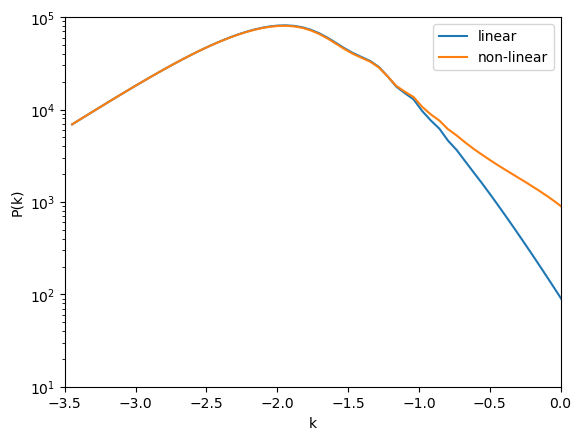

In [11]:
plt.plot(k_cheb, PK.P(0,10 ** k_cheb), label = "linear")
plt.plot(k_cheb, PK_nl.P(0,10 ** k_cheb), label = "non-linear")
plt.xlim(-3.5, 0)
plt.ylim(10, 1e5)
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("P(k)")
plt.legend();

So camb is generating a power spectrum that makes sense. For the non-limber computation, I evaluate the __linear__ power spectrum on the grid of chebpoints previously defined. The __non-linear__ contributions are computed using the Limber approximation. For that calculation, I also evaluate this object on a finer grid in both k and z. You can see this in the camb_cls.ipynb, towards the end.

Although the power spectrum is generated with CAMB, I am not sure about what P(k) camb is internally using when I call the function to compute the $C_\ell$'s, I still need to better check this. It is also important to note that both blast and CCL treat the power spectrum as $$P_\delta(k,\chi_1,\chi_2)=P_{\mathrm{lin}}(k,\chi_1,\chi_2)+[P_\delta-P_{\mathrm{lin}}](k,\chi_1,\chi_2),$$ which implies $$C^{\mathrm{tot}}(\ell)=C_{\mathrm{lin}}(\ell)+C_\delta^{\mathrm{limb}}-C_{\mathrm{lin}}^{\mathrm{limb}}.$$
For CAMB, I'm not sure about what the algorithm does in that sense. All of this to say that, even though I have the $C_\ell$'s computed with CAMB, CCL is way more under control for now. 

For what concerns CCL, the package internally computes the power spectrum used for the evaluation of the $C_\ell$'s. But there is an option to call CAMB to do that: so I made sure that the power spectrum that CCL generates matches to the one that I generated with CAMB and is passed to BLAST.

## CCL power spectrum

In [12]:
# Cosmology
camb_params = {"camb": {"halofit_version": "takahashi"}}

cosmo = ccl.Cosmology(Omega_c=Odm, Omega_b=Ob, h=h0, A_s=As, n_s=ns, matter_power_spectrum='camb', extra_parameters=camb_params)

In [13]:
ccl_lin_pk = cosmo.get_linear_power()
ccl_nl_pk = cosmo.get_nonlin_power()

In [14]:
# LOAD THE CAMB POWER SPECGTRUM THAT IS USED IN BLAST
k = np.load("data/k_nl.npz")["arr_0"]
z = np.load("data/z_nl.npz")["arr_0"]
a = 1/(1+z)
pk_nl_camb = np.load("data/camb_nl_pk.npz")["arr_0"]
pk_lin_camb = np.load("data/camb_lin_pk.npz")["arr_0"]

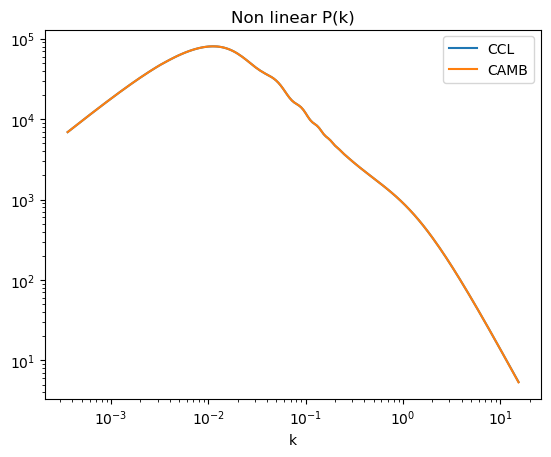

In [15]:
plt.loglog(k, ccl_nl_pk(k, a[0]), label = "CCL")
plt.loglog(k, pk_nl_camb[0,:], label = "CAMB")
plt.legend()
plt.xlabel("k")
plt.title("Non linear P(k)");

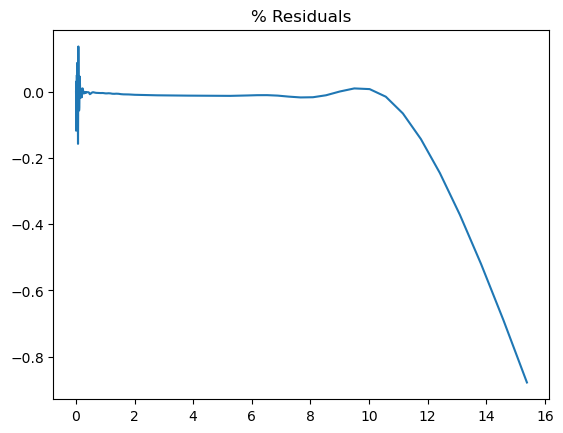

In [16]:
plt.plot(k, 100*(1-ccl_nl_pk(k, a[0])/pk_nl_camb[0,:]))
plt.title("% Residuals");

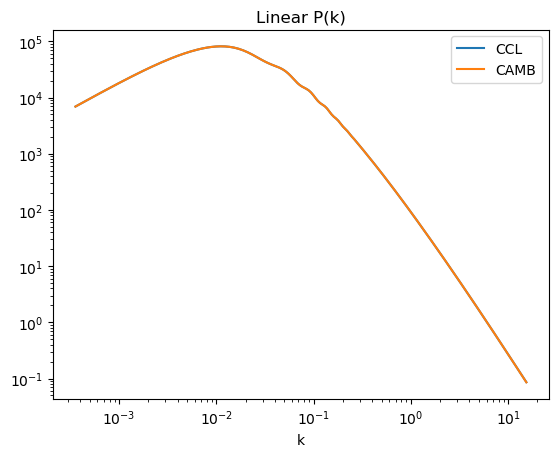

In [17]:
plt.loglog(k, ccl_lin_pk(k, a[0]), label = "CCL")
plt.loglog(k, pk_lin_camb[0,:], label = "CAMB")
plt.legend()
plt.xlabel("k")
plt.title("Linear P(k)");

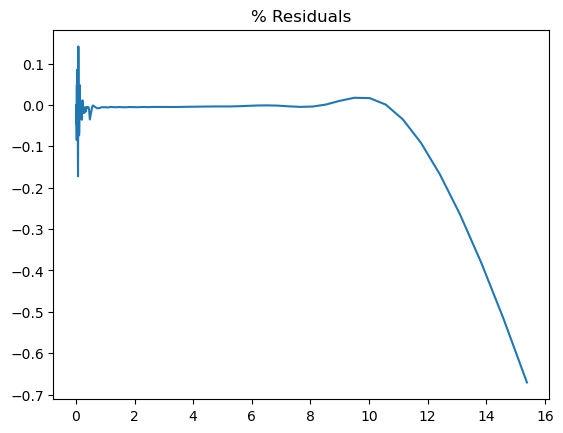

In [18]:
plt.plot(k, 100*(1-ccl_lin_pk(k, a[0])/pk_lin_camb[0,:]))
plt.title("% Residuals");

So, the point is that BLAST and CCL are using the same exact power spectrum and they treat it in the same way. CAMB needs more investigation. (is it weird that residuals have the exact same shape?)

## Window functions

To assess every possible source of discrepancy, I also checked the window functions for BLAST and CCL. Again, not sure if I can do it for CAMB.

In [19]:
z = np.linspace(0,5,1024)
nz1 = np.interp(z,dndz[0],dndz[1]) 
bz = np.ones_like(z) #set bias to 1. Same as done for BLAST

cmbl = ccl.CMBLensingTracer(cosmo, z_source=1089.)
cclg = ccl.NumberCountsTracer(cosmo,dndz=(z,nz1),bias=(z,bz),has_rsd=False)
ccls = ccl.tracers.WeakLensingTracer(cosmo, dndz=(z,nz1))

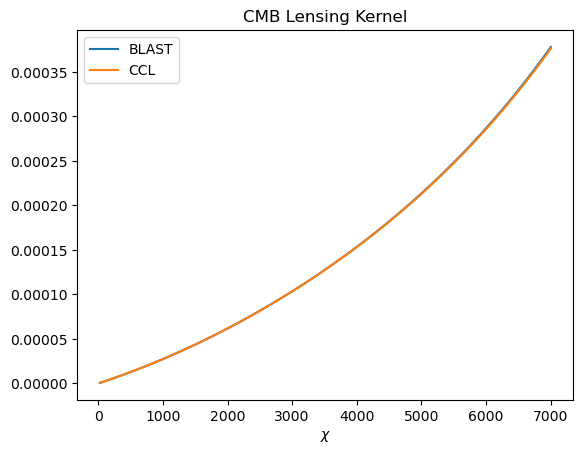

In [20]:
chi = np.linspace(26,7000, 96)
blast_cmb = np.load("data/cmb_kernel.npy")
plt.plot(chi, blast_cmb, label="BLAST")
plt.plot(chi, cmbl.get_kernel(chi)[0,:], label="CCL")
plt.xlabel(r"$\chi$")
plt.legend()
plt.title("CMB Lensing Kernel");

Text(0.5, 1.0, '% Residuals')

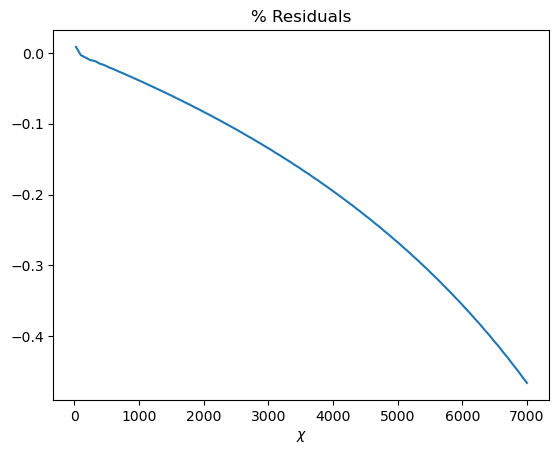

In [21]:
plt.plot(chi, 100*(1-blast_cmb/cmbl.get_kernel(chi)[0,:]))
plt.xlabel(r"$\chi$")
plt.title("% Residuals")

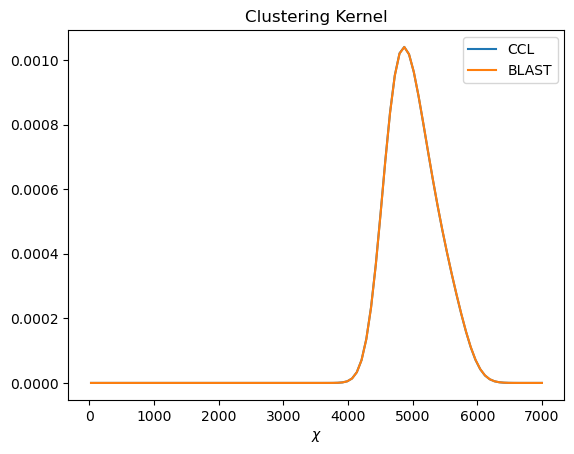

In [22]:
plt.plot(chi, cclg.get_kernel(chi)[0,:], label="CCL")
blast_gal = np.load("data/galaxy_kernel.npy")
plt.plot(chi, blast_gal, label="BLAST")
plt.xlabel(r"$\chi$")
plt.legend()
plt.title("Clustering Kernel");

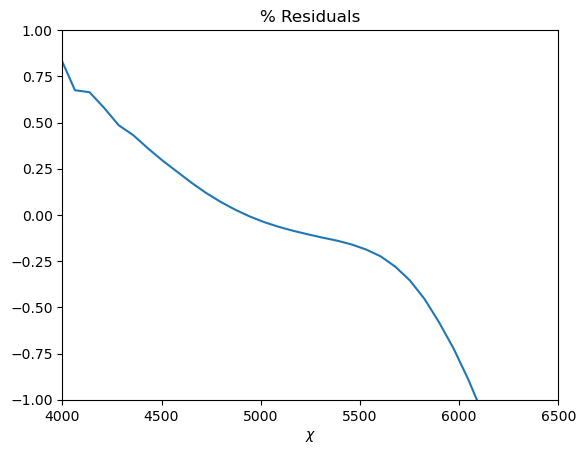

In [23]:
#These residuals have problem bc of the division b y zero. But on the relevant range the differences are small but present.
plt.plot(chi, 100*(1-blast_gal/cclg.get_kernel(chi)[0,:]))
plt.xlabel(r"$\chi$")
plt.xlim((4000,6500))
plt.ylim((-1,1))
plt.title("% Residuals");

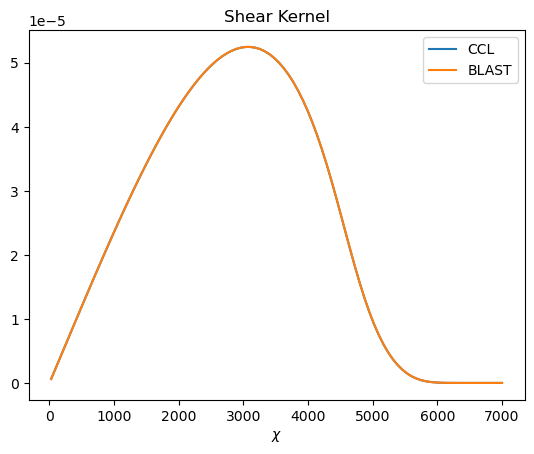

In [24]:
plt.plot(chi, ccls.get_kernel(chi)[0,:], label="CCL")
blast_sh = np.load("data/shear_kernel.npy")
plt.plot(chi, blast_sh, label="BLAST")
plt.xlabel(r"$\chi$")
plt.legend()
plt.title("Shear Kernel");

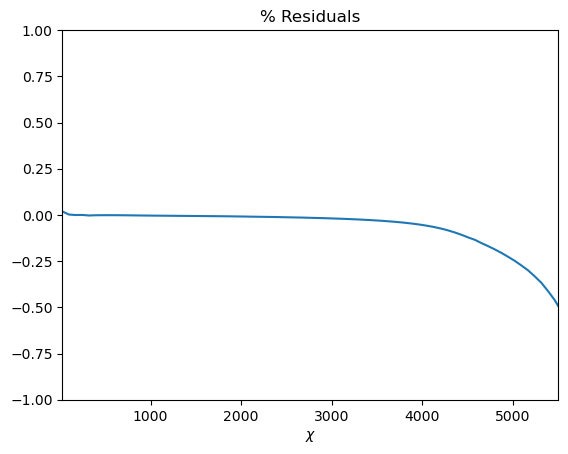

In [25]:
plt.plot(chi, 100*(1-blast_sh/ccls.get_kernel(chi)[0,:]))
plt.xlim((26, 5500))
plt.ylim((-1,1))
plt.xlabel(r"$\chi$")
plt.title("% Residuals");

So I'm not completely messing up the kernels, but the differences need to be investigated (may simply be caused by interpolation). To eliminate any possible discrepancy arising from this, I saved the ccl kernels and I load them into BLAST (you can see this in the blast_cls.ipynb), so the kernels are the exact same.

## Finally computing the $C_\ell$'s

### CCL

In [26]:
ccells = np.linspace(2, 2000, 900)
cl_gg_ccl = ccl.angular_cl(cosmo, cclg, cclg, ccells, l_limber=200, return_meta=False)
cl_ss_ccl = ccl.angular_cl(cosmo, ccls, ccls, ccells, l_limber=200, return_meta=False)
cl_gs_ccl = ccl.angular_cl(cosmo, cclg, ccls, ccells, l_limber=200, return_meta=False)
cl_kg_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=200, return_meta=False)
cl_ks_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=200, return_meta=False)

### CAMB

In [27]:
zint = np.linspace(0,5,1024)
dndz = [zint,np.interp(zint,dndz[0],dndz[1])]

#set bias to 1, like in blast and ccl
zs_p = np.array(dndz[0])
ks = np.logspace(np.log10(1e-4), np.log10(15), len(zs_p))
bias_kz = np.ones((len(ks), len(zs_p)))
    
for _i,z_i in enumerate(zs_p):
        bias_kz[:,_i] = 1.

W = np.array(dndz[1])

In [28]:
#define window functions
pars_nolimber.SourceWindows = [SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W, source_type='counts', dlog10Ndm = 0.39),
SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W, source_type='lensing', dlog10Ndm = 0.39)]

'pars_nolimber.SourceWindows' is not callable, I can't plot it and check what is happening. I really need to look into that because this is probably where the differences arise. Anyway...

In [29]:
lmax_plot = 200

results_nolimber = camb.get_results(pars_nolimber)
cls_nolimber = results_nolimber.get_source_cls_dict(raw_cl=True)
camb_ells = np.arange(1, cls_nolimber["W1xW1"].shape[0])[2:lmax_plot+1]
#camb_ells = np.arange(2, lmax_plot+1)

## Comparison Plots

In [30]:
#load blast cl's. You can check how they're computed in the blast_cls notebook. They include the non-linear part. Also, for some reason they are already saved as l(l+1)Cl
ell_list = np.load("data/ell_list.npy")
blast_gg = np.load("blast_cls/D_gg.npy")
blast_ss = np.load("blast_cls/D_ss.npy")
blast_gs = np.load("blast_cls/D_gs.npy")
blast_gcmbl = np.load("blast_cls/D_gcmbl.npy")
blast_scmbl = np.load("blast_cls/D_scmbl.npy")

In [31]:
#interpolate objects so I can show residuals
new_ccl_gg = np.interp(ell_list, ccells, cl_gg_ccl)
new_camb_gg = np.interp(ell_list, camb_ells, cls_nolimber["W1xW1"][2:lmax_plot+1])

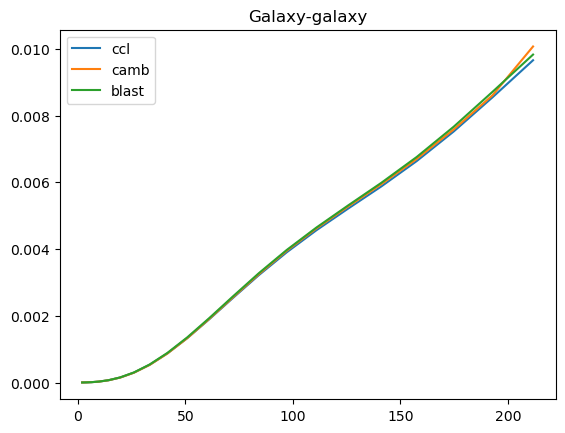

In [32]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_gg, label="ccl" )
plt.plot(ell_list, ell_list*(ell_list+1)*new_camb_gg, label = "camb")
plt.plot(ell_list, blast_gg, label="blast")
plt.legend()
plt.title("Galaxy-galaxy");

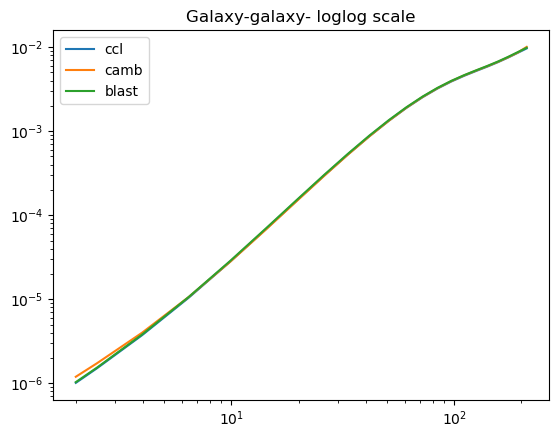

In [33]:
plt.loglog(ell_list, ell_list * (ell_list +1) * new_ccl_gg, label="ccl" )
plt.loglog(ell_list, ell_list*(ell_list+1)*new_camb_gg, label = "camb")
plt.loglog(ell_list, blast_gg, label="blast")
plt.legend()
plt.title("Galaxy-galaxy- loglog scale");

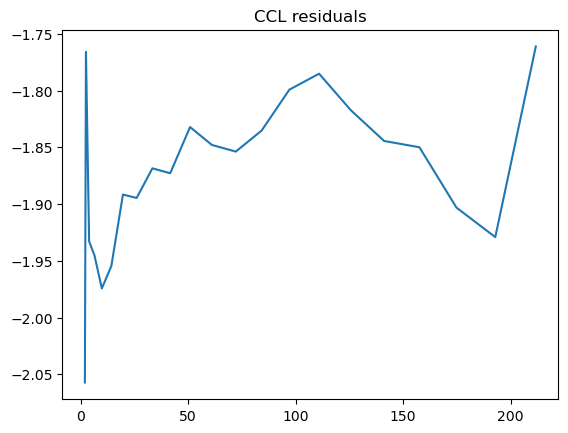

In [34]:
plt.plot(ell_list, 100*(1-blast_gg/(ell_list * (ell_list +1) * new_ccl_gg)), label="ccl")
plt.title("CCL residuals");

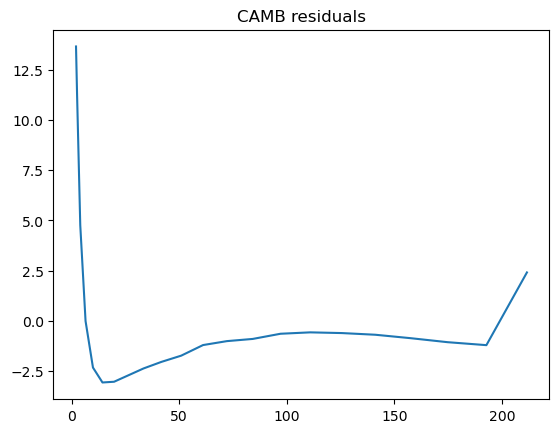

In [35]:
plt.plot(ell_list, 100*(1-blast_gg/(ell_list * (ell_list +1) * new_camb_gg)), label="camb")
plt.title("CAMB residuals");

In [36]:
#interpolate objects so I can show residuals
new_ccl_gs = np.interp(ell_list, ccells, cl_gs_ccl)
new_camb_gs = np.interp(ell_list, camb_ells, cls_nolimber["W1xW2"][2:lmax_plot+1])

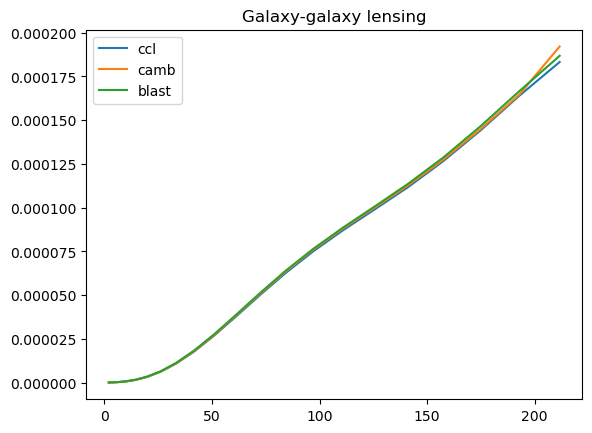

In [37]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_gs, label="ccl" )
plt.plot(ell_list, ell_list*(ell_list+1)*new_camb_gs, label = "camb")
plt.plot(ell_list, blast_gs, label="blast")
plt.legend()
plt.title("Galaxy-galaxy lensing");

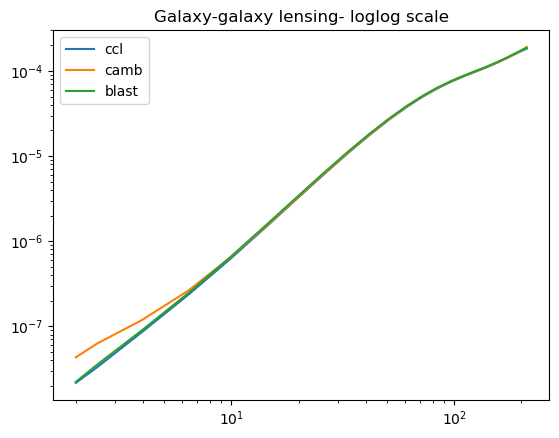

In [38]:
plt.loglog(ell_list, ell_list * (ell_list +1) * new_ccl_gs, label="ccl" )
plt.loglog(ell_list, ell_list*(ell_list+1)*new_camb_gs, label = "camb")
plt.loglog(ell_list, blast_gs, label="blast")
plt.legend()
plt.title("Galaxy-galaxy lensing- loglog scale");

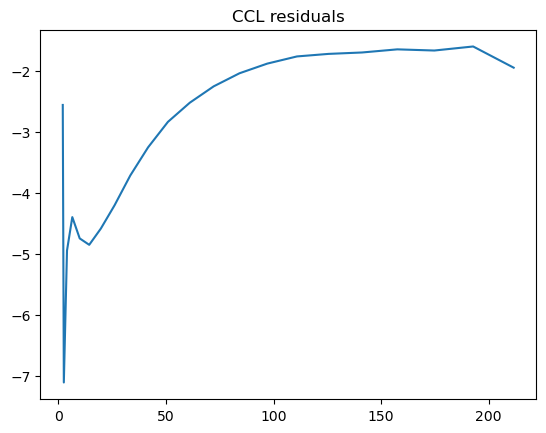

In [39]:
plt.plot(ell_list, 100*(1-blast_gs/(ell_list * (ell_list +1) * new_ccl_gs)), label="ccl")
plt.title("CCL residuals");

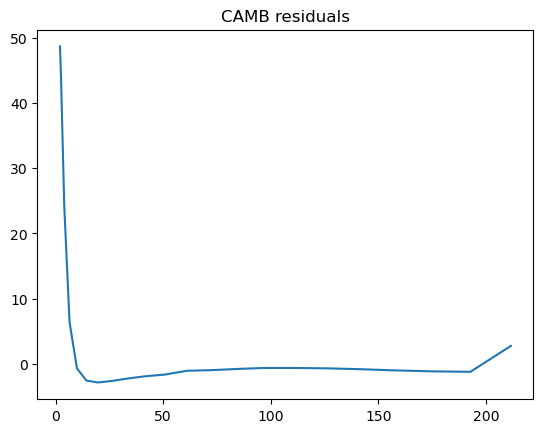

In [40]:
plt.plot(ell_list, 100*(1-blast_gs/(ell_list * (ell_list +1) * new_camb_gs)), label="camb")
plt.title("CAMB residuals");

In [41]:
#interpolate objects so I can show residuals
new_ccl_ss = np.interp(ell_list, ccells, cl_ss_ccl)
new_camb_ss = np.interp(ell_list, camb_ells, cls_nolimber["W2xW2"][2:lmax_plot+1])

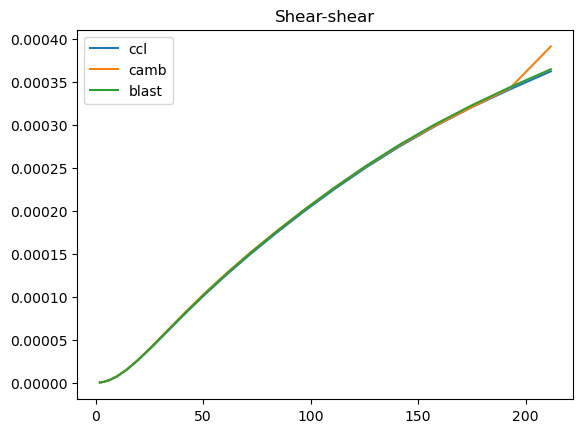

In [42]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_ss, label="ccl" )
plt.plot(ell_list, ell_list*(ell_list+1)*new_camb_ss, label = "camb")
plt.plot(ell_list, blast_ss, label="blast")
plt.legend()
plt.title("Shear-shear");

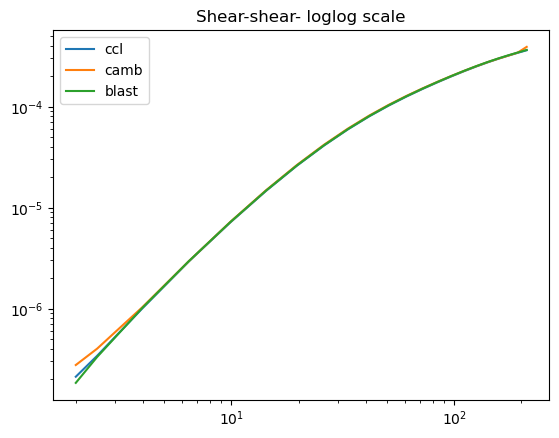

In [43]:
plt.loglog(ell_list, ell_list * (ell_list +1) * new_ccl_ss, label="ccl" )
plt.loglog(ell_list, ell_list*(ell_list+1)*new_camb_ss, label = "camb")
plt.loglog(ell_list, blast_ss, label="blast")
plt.legend()
plt.title("Shear-shear- loglog scale");

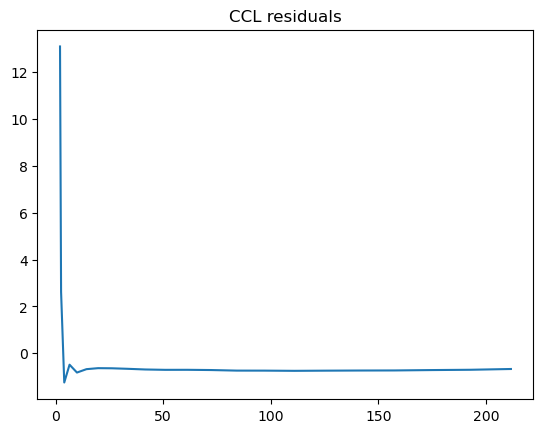

In [44]:
plt.plot(ell_list, 100*(1-blast_ss/(ell_list * (ell_list +1) * new_ccl_ss)), label="ccl")
plt.title("CCL residuals");

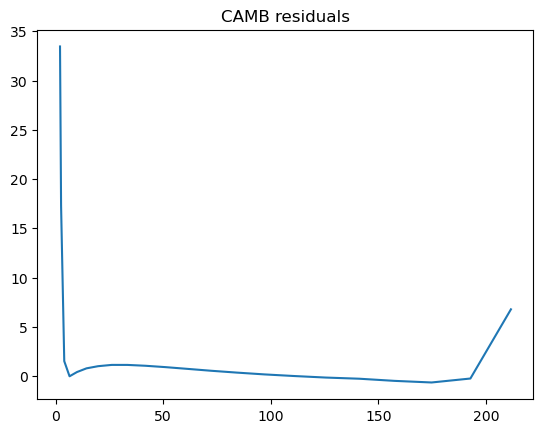

In [45]:
plt.plot(ell_list, 100*(1-blast_ss/(ell_list * (ell_list +1) * new_camb_ss)), label="camb")
plt.title("CAMB residuals");

In [46]:
#interpolate objects so I can show residuals
new_ccl_kg = np.interp(ell_list, ccells, cl_kg_ccl)
new_camb_kg = np.interp(ell_list, camb_ells, cls_nolimber["PxW1"][2:lmax_plot+1])

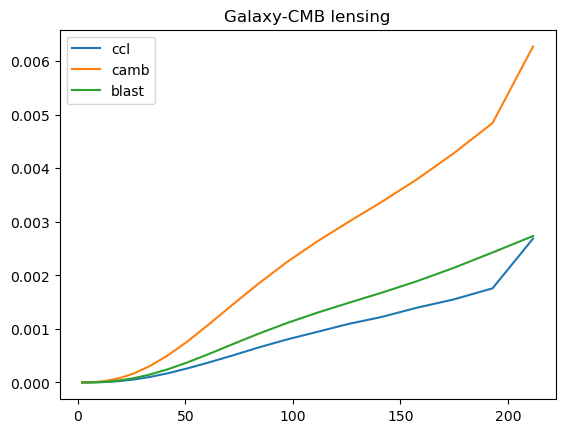

In [47]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_kg, label="ccl" )
plt.plot(ell_list, (ell_list * (ell_list+1))**2 * new_camb_kg, label = "camb")
plt.plot(ell_list, blast_gcmbl, label="blast")
plt.legend()
plt.title("Galaxy-CMB lensing");

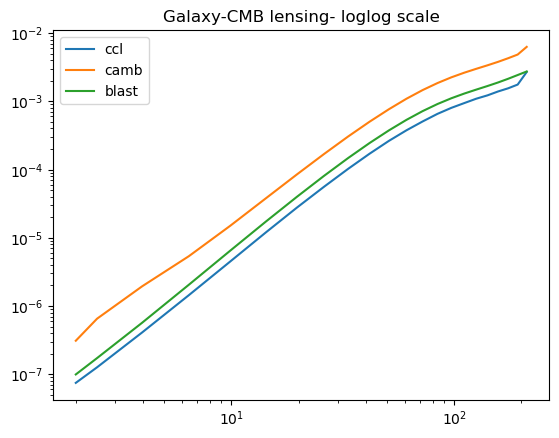

In [48]:
plt.loglog(ell_list, ell_list * (ell_list +1) * new_ccl_kg, label="ccl" )
plt.loglog(ell_list, (ell_list * (ell_list+1))**(2) * new_camb_kg, label = "camb")
plt.loglog(ell_list, blast_gcmbl, label="blast")
plt.legend()
plt.title("Galaxy-CMB lensing- loglog scale");

Here I figured out that camb wants (l(l+1))^2 by looking at the source code for 'get_source_cls_dict(raw_cl=True)'. Plotting the residuals is kinda pointless since everything is bad, also, I need to figure put what is breaking CCL. It really depend on the l grid you choose to do the computation (ccells).

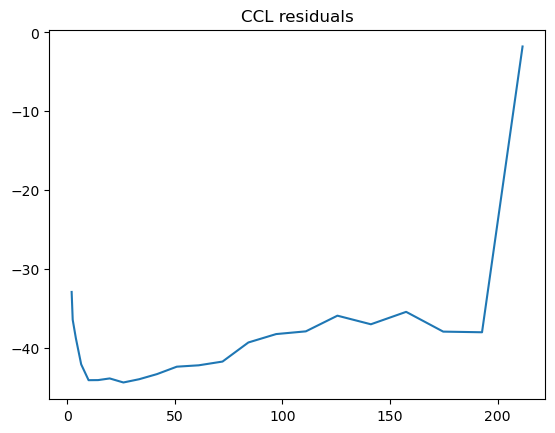

In [49]:
plt.plot(ell_list, 100*(1-blast_gcmbl/(ell_list * (ell_list +1) * new_ccl_kg)), label="ccl")
plt.title("CCL residuals");

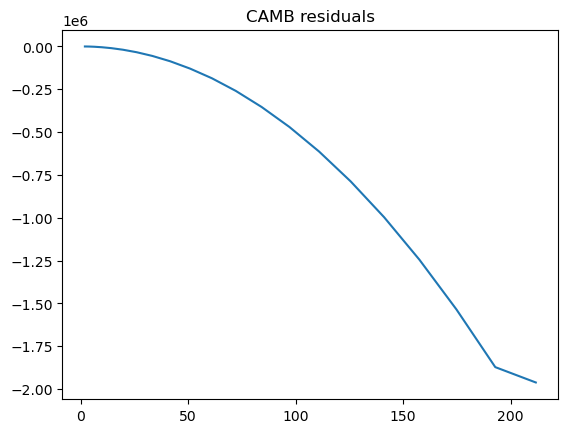

In [50]:
plt.plot(ell_list, 100*(1-blast_gcmbl/(ell_list * (ell_list +1) * new_camb_kg)), label="camb")
plt.title("CAMB residuals");

In [51]:
#interpolate objects so I can show residuals
new_ccl_ks = np.interp(ell_list, ccells, cl_ks_ccl)
new_camb_ks = np.interp(ell_list, camb_ells, cls_nolimber["PxW2"][2:lmax_plot+1])

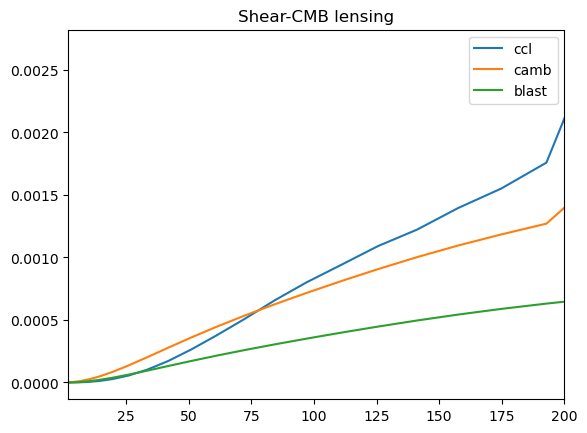

In [52]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_ks, label="ccl" )
plt.plot(ell_list, (ell_list * (ell_list+1))**2 * new_camb_ks, label = "camb")
plt.plot(ell_list, blast_scmbl, label="blast")
plt.legend()
plt.xlim((2,200))
plt.title("Shear-CMB lensing");

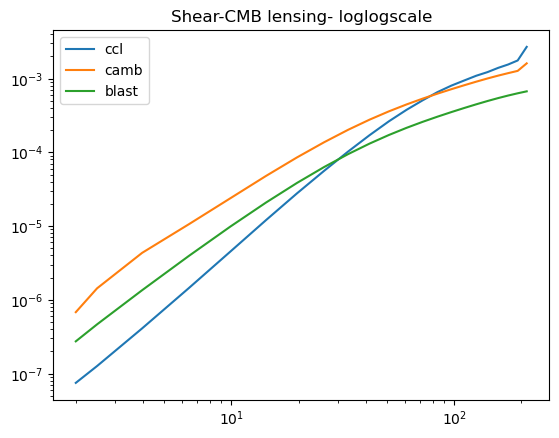

In [53]:
plt.loglog(ell_list, ell_list * (ell_list +1) * new_ccl_ks, label="ccl" )
plt.loglog(ell_list, (ell_list * (ell_list+1))**2 * new_camb_ks, label = "camb")
plt.loglog(ell_list, blast_scmbl, label="blast")
plt.legend()
plt.title("Shear-CMB lensing- loglogscale");

Again, plotting residuals is almost pointless here, but here we go..

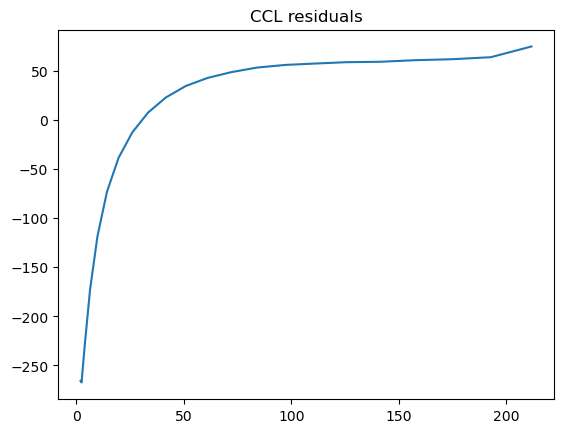

In [54]:
plt.plot(ell_list, 100*(1-blast_scmbl/(ell_list * (ell_list +1) * new_ccl_ks)), label="ccl")
plt.title("CCL residuals");

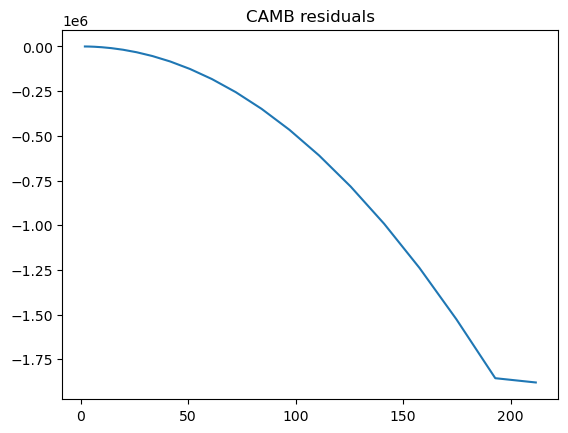

In [55]:
plt.plot(ell_list, 100*(1-blast_scmbl/(ell_list * (ell_list +1) * new_camb_ks)), label="camb")
plt.title("CAMB residuals");

Also, something is breaking camb al l=200 clearly. Need to figure it out too.

# Comparing directly to FKEM 

What I did is taking the scripts created for N5K, and adapt them to read my input files (power spectrum, kernels). In this way, FKEM is way more under control since I can check the $\ell$ prefactors and more importantly the non linear contributions are added. 

In [56]:
pure_blast_gg = np.load("blast_cls/blast_gg.npy")
pure_blast_ss = np.load("blast_cls/blast_ss.npy")
pure_blast_gs = np.load("blast_cls/blast_gs.npy")
pure_blast_gcmbl = np.load("blast_cls/blast_gcmbl.npy")
pure_blast_scmbl = np.load("blast_cls/blast_scmbl.npy");

In [57]:
D_gg = np.load("blast_cls/D_gg.npy")
D_ss = np.load("blast_cls/D_ss.npy")
D_gs = np.load("blast_cls/D_gs.npy")
D_gcmbl = np.load("blast_cls/D_gcmbl.npy")
D_scmbl = np.load("blast_cls/D_scmbl.npy");

In [58]:
cls_gg = np.load("FKEM/outputs/fkem_clgg.npz")
cls_gs = np.load("FKEM/outputs/fkem_clgs.npz")
cls_ss = np.load("FKEM/outputs/fkem_clss.npz")

cls_gg_pure = np.load("FKEM/outputs/fkem_gg_pure.npz")["arr_0"]
cls_gs_pure = np.load("FKEM/outputs/fkem_gs_pure.npz")["arr_0"]
cls_ss_pure = np.load("FKEM/outputs/fkem_ss_pure.npz")["arr_0"]

In [59]:
l_fkem = cls_gg["ls"][cls_gg["ls"]<200]
gg_fkem = cls_gg["cls"][0][cls_gg["ls"]<200]
gs_fkem = cls_gs["cls"][0][cls_gg["ls"]<200]
ss_fkem = cls_ss["cls"][0][cls_gg["ls"]<200]

In [71]:
limber_gg = np.load("blast_cls/blast_gg_lin.npy")
limber_gs = np.load("blast_cls/blast_gs_lin.npy")
limber_ss = np.load("blast_cls/blast_ss_lin.npy")
limber_gk = np.load("blast_cls/blast_gcmbl_lin.npy")
limber_sk = np.load("blast_cls/blast_scmbl_lin.npy")

limber_gg_nl = np.load("blast_cls/blast_gg_nonlin.npy")
limber_gs_nl = np.load("blast_cls/blast_gs_nonlin.npy")
limber_ss_nl = np.load("blast_cls/blast_ss_nonlin.npy")
limber_gk_nl = np.load("blast_cls/blast_gcmbl_nonlin.npy")
limber_sk_nl = np.load("blast_cls/blast_scmbl_nonlin.npy")

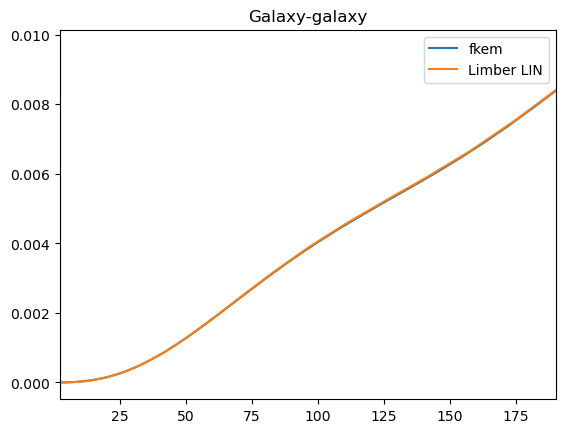

In [61]:
plt.plot(l_fkem, l_fkem*(l_fkem+1)*(gg_fkem), label="fkem")
#plt.plot(l_fkem, l_fkem*(l_fkem+1)*cls_gg_pure, label="pure fkem")
#plt.plot(ell_list, pure_blast_gg, label="pure blast")
plt.plot(ell_list, limber_gg, label="Limber LIN")
#plt.plot(ell_list, limber_gg_nl, label="Limber NL")
#plt.plot(ell_list, D_gg, label="blast")
#plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_gg, label="ccl" )
plt.legend()
#plt.yscale("log")
#plt.xscale("log")
plt.xlim(2,190)
plt.title("Galaxy-galaxy");

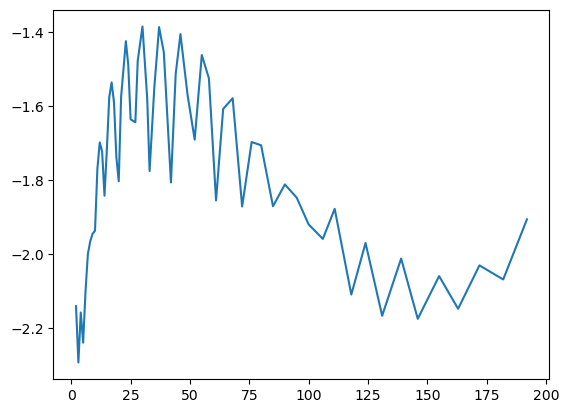

In [62]:
import scipy as sp
gg = sp.interpolate.interp1d(ell_list, D_gg/(ell_list*(ell_list+1)))
plt.plot(l_fkem, 100*(1 - gg(l_fkem)/gg_fkem))

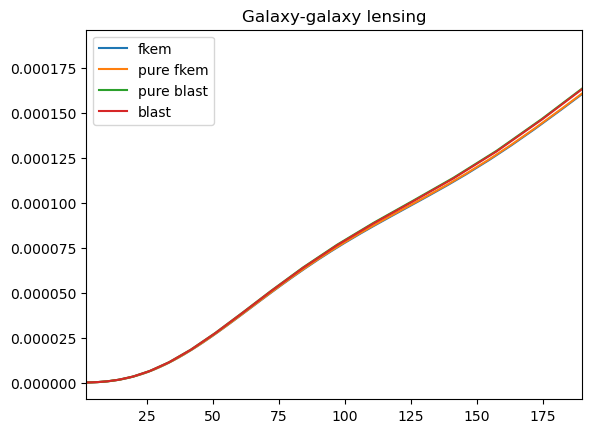

In [63]:
plt.plot(l_fkem, l_fkem*(l_fkem+1)*gs_fkem, label="fkem")
plt.plot(l_fkem, l_fkem*(l_fkem+1)*cls_gs_pure, label="pure fkem")
plt.plot(ell_list, pure_blast_gs, label="pure blast")
#plt.plot(ell_list, limber_gs, label="Limber LIN")
#plt.plot(ell_list, limber_gs_nl, label="Limber NL")
plt.plot(ell_list, D_gs, label="blast")
#plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_gs, label="ccl" )
plt.legend()
#plt.yscale("log")
#plt.xscale("log")
plt.xlim(2,190)
plt.title("Galaxy-galaxy lensing");

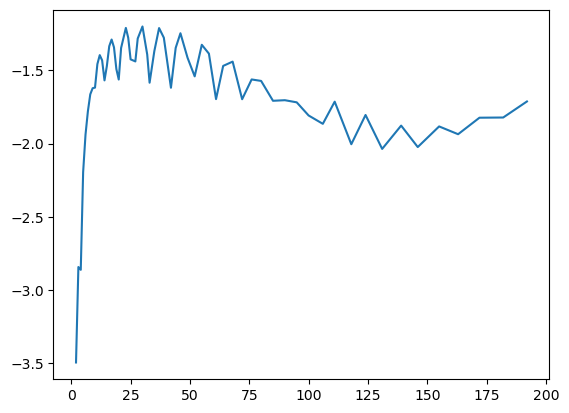

In [64]:
gs = sp.interpolate.interp1d(ell_list, D_gs/(ell_list*(ell_list+1)))
plt.plot(l_fkem, 100*(1 - gs(l_fkem)/gs_fkem))

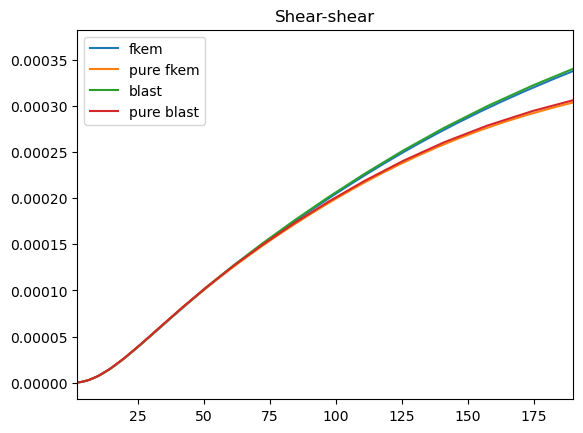

In [65]:
plt.plot(l_fkem, l_fkem*(l_fkem+1)*ss_fkem, label="fkem")
plt.plot(l_fkem, l_fkem*(l_fkem+1)*cls_ss_pure, label="pure fkem")
plt.plot(ell_list, D_ss, label="blast")
plt.plot(ell_list, pure_blast_ss, label="pure blast")
#plt.plot(ell_list, limber_ss, label="Limber LIN")
#plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_ss, label="ccl" )
plt.legend()
#plt.yscale("log")
plt.xlim(2,190)
plt.title("Shear-shear");

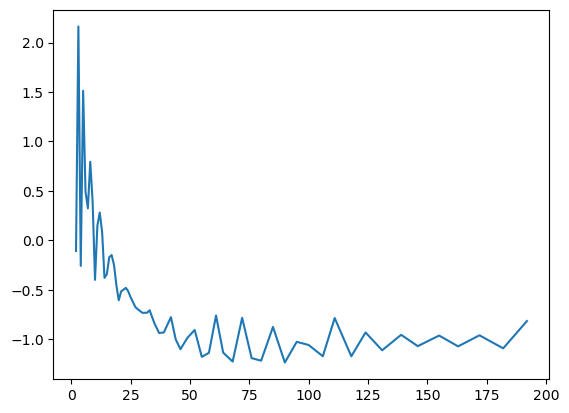

In [66]:
ss = sp.interpolate.interp1d(ell_list, D_ss/(ell_list*(ell_list+1)))
plt.plot(l_fkem, 100*(1 -ss(l_fkem)/ss_fkem))

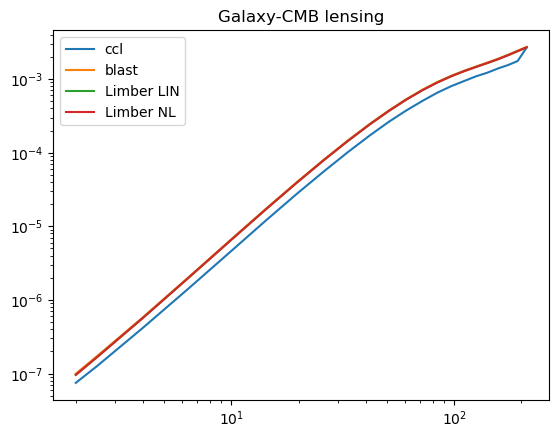

In [76]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_kg, label="ccl" )
plt.plot(ell_list, D_gcmbl, label="blast")
plt.plot(ell_list, limber_gk, label="Limber LIN")
plt.plot(ell_list, limber_gk_nl, label="Limber NL")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Galaxy-CMB lensing");

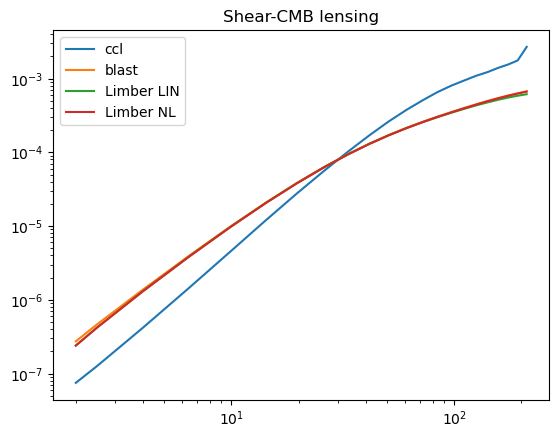

In [77]:
plt.plot(ell_list, ell_list * (ell_list +1) * new_ccl_ks, label="ccl" )
plt.plot(ell_list, D_scmbl, label="blast")
plt.plot(ell_list, limber_sk, label="Limber LIN")
plt.plot(ell_list, limber_sk_nl, label="Limber NL")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Shear-CMB lensing");